Madoria-EDA

My analysis is on the gross profit in the domestic vs foreign box office market and the production budget. My analysis utilizes the movie_gross, movie_budgets, and tmbd_movies charts:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

After importing, pandas and matplotlib, I decided to get a peek of the data including a description of each of the table values and begin cleaning. Starting with the bom.movie_gross data:

In [2]:
df1= pd.read_csv('data/bom.movie_gross.csv')
df1.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
gross= df1[df1['studio'].notna() & df1['domestic_gross'].notna()]
gross

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [5]:
gross['foreign_gross']= gross['foreign_gross'].fillna(0)

<ipython-input-5-29bb5cd67e81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross['foreign_gross']= gross['foreign_gross'].fillna(0)


In [6]:
gross['foreign_gross'] = gross['foreign_gross'].str.replace(',', '').astype(float)

<ipython-input-6-75ad6d22bf88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross['foreign_gross'] = gross['foreign_gross'].str.replace(',', '').astype(float)


In [7]:
gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   2007 non-null   float64
 4   year            3356 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB


In [8]:
top_10_studios_domestic= gross.groupby('studio')['domestic_gross'].sum().sort_values(ascending=False).head(10)
top_10_studios_domestic

studio
BV         1.841903e+10
Uni.       1.290239e+10
WB         1.216805e+10
Fox        1.094950e+10
Sony       8.459683e+09
Par.       7.685871e+09
LGF        4.118963e+09
WB (NL)    3.995700e+09
LG/S       2.078200e+09
P/DW       1.682900e+09
Name: domestic_gross, dtype: float64

In [10]:
top_10_studios_foreign= gross.groupby('studio')['foreign_gross'].sum().sort_values(ascending=False).head(10)
top_10_studios_foreign

studio
BV         2.579385e+10
Fox        2.005587e+10
WB         1.866790e+10
Uni.       1.685477e+10
Sony       1.394524e+10
Par.       1.186338e+10
WB (NL)    6.339000e+09
LGF        4.475619e+09
P/DW       3.393600e+09
LG/S       3.353724e+09
Name: foreign_gross, dtype: float64

Now I move on to tn.movie budgets and do some more cleaning:

In [12]:
df2= pd.read_csv('data/tn.movie_budgets.csv')
df2.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [14]:
cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
df2[cols] = df2[cols].replace('[\$,]','', regex=True).astype(float)
df2

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000.0,0.0,0.000000e+00
5778,79,"Apr 2, 1999",Following,6000.0,48482.0,2.404950e+05
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400.0,0.0,0.000000e+00


In [15]:
"""I was going to do percent, but I believe this is still understandable"""

df2['dom_profit_margin']= (df2['domestic_gross'] - df2['production_budget']) / df2['domestic_gross']
df2['ww_profit_margin']= (df2['worldwide_gross'] - df2['production_budget'])/ df2['worldwide_gross']
df2

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,dom_profit_margin,ww_profit_margin
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,0.441163,0.846921
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,-0.703283,0.607331
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-7.184770,-1.337036
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,0.279748,0.764364
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,0.488859,0.759251
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000.0,0.0,0.000000e+00,-inf,-inf
5778,79,"Apr 2, 1999",Following,6000.0,48482.0,2.404950e+05,0.876243,0.975051
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,-2.736921,-2.736921
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400.0,0.0,0.000000e+00,-inf,-inf


In [16]:
top_20_movies_worldwide= df2.nlargest(20, 'worldwide_gross')['movie'].reset_index()
top_20_movies_worldwide 

,index,movie
0,0,Avatar
1,42,Titanic
2,5,Star Wars Ep. VII: The Force Awakens
3,6,Avengers: Infinity War
4,33,Jurassic World
5,66,Furious 7
6,26,The Avengers
7,3,Avengers: Age of Ultron
8,41,Black Panther
9,260,Harry Potter and the Deathly Hallows: Part II


Text(0, 0.5, 'Worldwide Gross (in billions)')

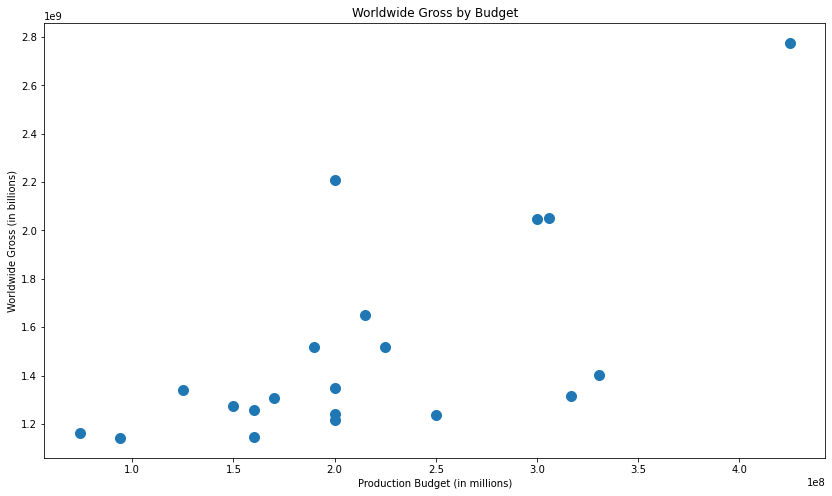

In [17]:
top_world_profit = df2.sort_values('worldwide_gross', ascending=False).iloc[:20]

fig, ax= plt.subplots(figsize=(14,8))

ax.scatter(top_world_profit['production_budget'], top_world_profit['worldwide_gross'], s=100)
ax.set_title("Worldwide Gross by Budget")
ax.set_xlabel("Production Budget (in millions)")
ax.set_ylabel("Worldwide Gross (in billions)")

In [18]:
top_10_movies_domestic= df2.nlargest(20, 'domestic_gross')['movie'].reset_index()
top_10_movies_domestic

,index,movie
0,5,Star Wars Ep. VII: The Force Awakens
1,0,Avatar
2,41,Black Panther
3,6,Avengers: Infinity War
4,42,Titanic
5,33,Jurassic World
6,26,The Avengers
7,4,Star Wars Ep. VIII: The Last Jedi
8,43,Incredibles 2
9,74,The Dark Knight


Text(0, 0.5, 'Domestic Gross (in 100 millions)')

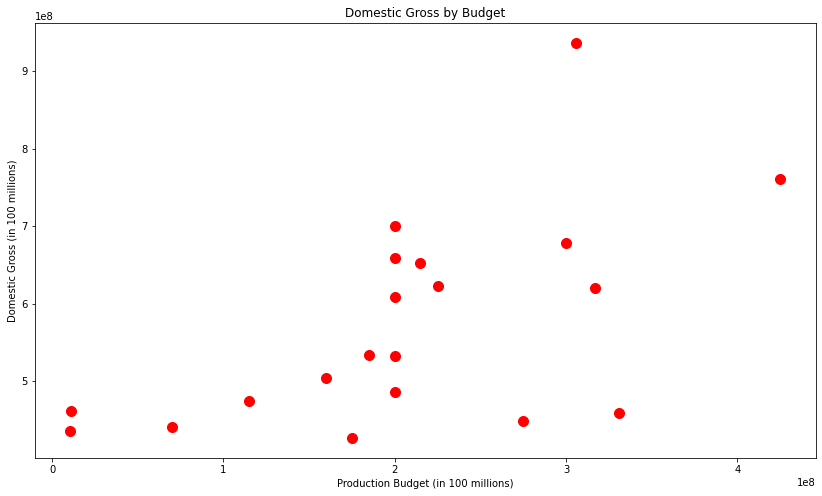

In [19]:
top_dom_profit = df2.sort_values('domestic_gross', ascending=False).iloc[:20]

fig, ax= plt.subplots(figsize=(14,8))

ax.scatter(top_dom_profit['production_budget'], top_dom_profit['domestic_gross'], c='r', s=100)
ax.set_title("Domestic Gross by Budget")
ax.set_xlabel("Production Budget (in 100 millions)")
ax.set_ylabel("Domestic Gross (in 100 millions)")

Based on the sample data I have, we've gotten some insight from the other two dataframes that:

 -certain studios seem to gross more than others whether foreign or domestic
 
 -there's a small correlation between the production budget and the overall gross

Now I'm moving on to the very last dataframe which is tmdb.movies just to see if anything ties into that:

In [73]:
df3= pd.read_csv('data/tmdb.movies.csv')
df3.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [74]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [75]:
df3.describe()

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [76]:
df3['vote_high_low']= ["High Votes" if x > 194 else "Low Votes" for x in df3['vote_count']]
df3.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,vote_high_low
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,High Votes
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,High Votes
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,High Votes
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,High Votes
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,High Votes


In [77]:
most_popular= df3.nlargest(20, 'popularity')['genre_ids'].sort_values()
most_popular

23815    [10751, 16, 35, 14, 12]
23811               [12, 28, 14]
23814                       [12]
23817          [28, 12, 14, 878]
11020               [28, 12, 14]
23812      [28, 12, 16, 878, 35]
20621           [28, 12, 35, 14]
23819           [28, 12, 35, 14]
20618          [28, 12, 878, 18]
23816          [28, 12, 878, 35]
14169              [28, 12, 878]
23820              [28, 12, 878]
20620              [28, 18, 878]
11019                   [28, 53]
11021              [28, 878, 12]
20619               [53, 28, 80]
5179               [878, 28, 12]
20617              [878, 28, 53]
23813              [878, 28, 53]
23818                  [878, 28]
Name: genre_ids, dtype: object

I can see here that certain genres do seem to appear more in the top 20 list, but I need more evidence to confirm. 

Combining Tables:

Here I want to combine the tables to get more insight on studio profits and hopefully have more insight on the genres. 

First to combine, the movie gross and movie budget dataframes:

In [30]:
new_movie= df1.merge(df2, left_on=df1['title'], right_on=df2['movie']).reset_index(drop=True)
new_movie

,key_0,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross,dom_profit_margin,ww_profit_margin
0,Toy Story 3,Toy Story 3,BV,415000000.0,652000000,2010,47,"Jun 18, 2010",Toy Story 3,200000000.0,415004880.0,1.068880e+09,0.518078,0.812888
1,Inception,Inception,WB,292600000.0,535700000,2010,38,"Jul 16, 2010",Inception,160000000.0,292576195.0,8.355246e+08,0.453134,0.808504
2,Shrek Forever After,Shrek Forever After,P/DW,238700000.0,513900000,2010,27,"May 21, 2010",Shrek Forever After,165000000.0,238736787.0,7.562447e+08,0.308862,0.781817
3,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,53,"Jun 30, 2010",The Twilight Saga: Eclipse,68000000.0,300531751.0,7.061028e+08,0.773734,0.903697
4,Iron Man 2,Iron Man 2,Par.,312400000.0,311500000,2010,15,"May 7, 2010",Iron Man 2,170000000.0,312433331.0,6.211564e+08,0.455884,0.726317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,Gotti,Gotti,VE,4300000.0,NaN,2018,64,"Jun 15, 2018",Gotti,10000000.0,4286367.0,6.089100e+06,-1.332978,-0.642279
1243,Ben is Back,Ben is Back,RAtt.,3700000.0,NaN,2018,95,"Dec 7, 2018",Ben is Back,13000000.0,3703182.0,9.633111e+06,-2.510494,-0.349512
1244,Bilal: A New Breed of Hero,Bilal: A New Breed of Hero,VE,491000.0,1700000,2018,100,"Feb 2, 2018",Bilal: A New Breed of Hero,30000000.0,490973.0,6.485990e+05,-60.103156,-45.253540
1245,Mandy,Mandy,RLJ,1200000.0,NaN,2018,71,"Sep 14, 2018",Mandy,6000000.0,1214525.0,1.427656e+06,-3.940203,-3.202693


In [ ]:
mega_movie= mega_movie.drop_duplicates(subset=['movie'], keep='first')

In [36]:
avg_studio= new_movie.groupby('studio').mean().reset_index()
avg_studio= avg_studio[avg_studio['dom_profit_margin'] > 0]
avg_studio

,studio,domestic_gross_x,year,id,production_budget,domestic_gross_y,worldwide_gross,dom_profit_margin,ww_profit_margin
0,3D,6.100000e+06,2010.000000,31.000000,5.000000e+06,6.096582e+06,1.651520e+07,0.179868,0.697249
4,Affirm,1.170000e+07,2017.500000,53.500000,3.500000e+06,1.167510e+07,1.573575e+07,0.685185,0.733780
12,BH Tilt,8.740000e+06,2016.600000,57.200000,2.800000e+06,8.717903e+06,1.323772e+07,0.616804,0.756000
16,CBS,2.654000e+07,2011.700000,54.500000,1.920000e+07,2.659037e+07,5.156630e+07,0.118588,0.473653
50,MBox,6.950000e+06,2012.000000,27.000000,4.630000e+07,5.317143e+07,1.273362e+08,0.221357,0.727033
51,MGM,8.300000e+07,2014.000000,53.000000,4.300000e+07,8.299287e+07,1.397796e+08,0.425886,0.610094
58,Neon,3.000000e+07,2017.000000,83.000000,1.100000e+07,3.001453e+07,5.379741e+07,0.633511,0.795529
61,Orch.,5.200000e+06,2016.000000,25.000000,2.500000e+06,5.205471e+06,2.384553e+07,0.519736,0.895159
64,P/DW,1.682900e+08,2010.900000,43.900000,1.334000e+08,1.682915e+08,5.078028e+08,0.015746,0.502563
66,PFR,1.370000e+07,2015.000000,70.500000,7.650000e+06,1.368985e+07,1.435432e+07,0.459866,0.468335


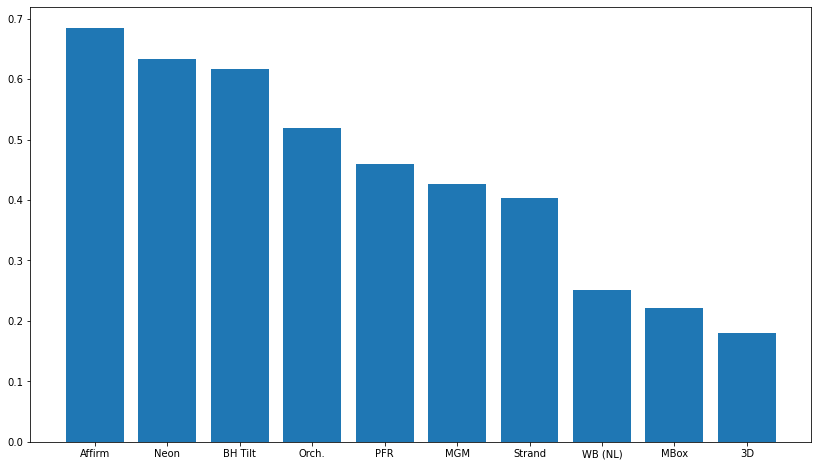

In [37]:
avg_studio = avg_studio.sort_values('dom_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(avg_studio['studio'], avg_studio['dom_profit_margin'])
ax.set_title= 'Top Studios'
ax.set_xlabel= 'Studios'
ax.set_ylabel= 'Domestic Profit Margin'

<AxesSubplot:xlabel='studio', ylabel='ww_profit_margin'>

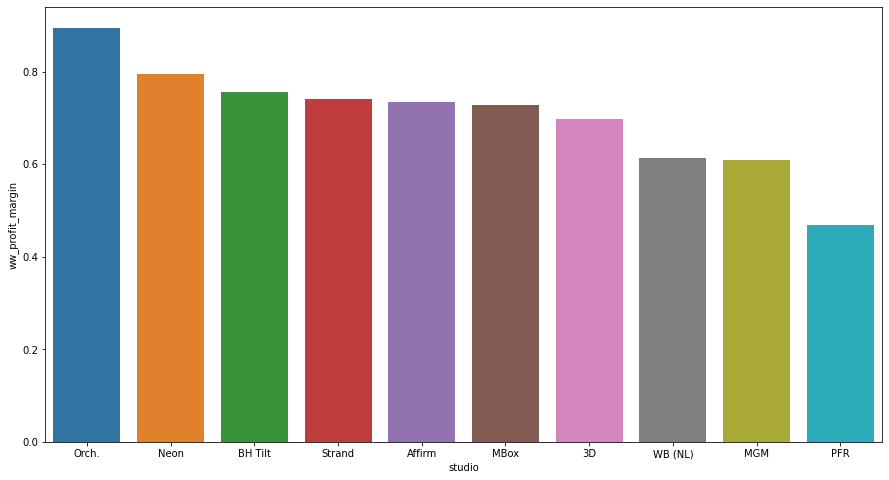

In [38]:
avg_studio = avg_studio.sort_values('ww_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(15,8))
sns.barplot(data=avg_studio, x='studio', y='ww_profit_margin')

This new studio information definitely differs from the lists up top. I'm going to continue to make sure it's not a fluke. 

Now I'll combine the combined dataframe I made just now with the very last movies dataframe. 

In [ ]:
"""Had to do this first to merge again"""
del new_movie['key_0']

In [78]:
mega_movie= new_movie.merge(df3, left_on=new_movie['title'], right_on=df3['title']).reset_index(drop=True)
mega_movie

,key_0,title_x,studio,domestic_gross_x,foreign_gross,year,id_x,release_date_x,movie,production_budget,...,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title_y,vote_average,vote_count,vote_high_low
0,Toy Story 3,Toy Story 3,BV,415000000.0,652000000,2010,47,"Jun 18, 2010",Toy Story 3,200000000.0,...,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,High Votes
1,Inception,Inception,WB,292600000.0,535700000,2010,38,"Jul 16, 2010",Inception,160000000.0,...,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,High Votes
2,Shrek Forever After,Shrek Forever After,P/DW,238700000.0,513900000,2010,27,"May 21, 2010",Shrek Forever After,165000000.0,...,"[35, 12, 14, 16, 10751]",10192,en,Shrek Forever After,15.041,2010-05-16,Shrek Forever After,6.1,3843,High Votes
3,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,53,"Jun 30, 2010",The Twilight Saga: Eclipse,68000000.0,...,"[12, 14, 18, 10749]",24021,en,The Twilight Saga: Eclipse,20.340,2010-06-23,The Twilight Saga: Eclipse,6.0,4909,High Votes
4,Iron Man 2,Iron Man 2,Par.,312400000.0,311500000,2010,15,"May 7, 2010",Iron Man 2,170000000.0,...,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,High Votes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,Bilal: A New Breed of Hero,Bilal: A New Breed of Hero,VE,491000.0,1700000,2018,100,"Feb 2, 2018",Bilal: A New Breed of Hero,30000000.0,...,"[28, 12, 16]",332718,en,Bilal: A New Breed of Hero,2.707,2018-02-02,Bilal: A New Breed of Hero,6.8,54,Low Votes
1391,Mandy,Mandy,RLJ,1200000.0,NaN,2018,71,"Sep 14, 2018",Mandy,6000000.0,...,[18],499658,en,Mandy,0.600,2016-01-24,Mandy,3.5,2,Low Votes
1392,Mandy,Mandy,RLJ,1200000.0,NaN,2018,71,"Sep 14, 2018",Mandy,6000000.0,...,"[28, 53, 27, 14, 9648]",460885,en,Mandy,16.240,2018-09-13,Mandy,6.2,618,High Votes
1393,Lean on Pete,Lean on Pete,A24,1200000.0,NaN,2018,13,"Apr 6, 2018",Lean on Pete,8000000.0,...,"[18, 12]",407890,en,Lean on Pete,9.307,2018-04-06,Lean on Pete,6.9,133,Low Votes


In [79]:
mega_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_0              1395 non-null   object 
 1   title_x            1395 non-null   object 
 2   studio             1394 non-null   object 
 3   domestic_gross_x   1393 non-null   float64
 4   foreign_gross      1200 non-null   object 
 5   year               1395 non-null   int64  
 6   id_x               1395 non-null   int64  
 7   release_date_x     1395 non-null   object 
 8   movie              1395 non-null   object 
 9   production_budget  1395 non-null   float64
 10  domestic_gross_y   1395 non-null   float64
 11  worldwide_gross    1395 non-null   float64
 12  dom_profit_margin  1395 non-null   float64
 13  ww_profit_margin   1395 non-null   float64
 14  Unnamed: 0         1395 non-null   int64  
 15  genre_ids          1395 non-null   object 
 16  id_y               1395 

There's dupes and nulls. Oh my

In [45]:
mega_dupes= mega_movie[mega_movie.duplicated(['movie'])]
mega_dupes

,key_0,title_x,studio,domestic_gross_x,foreign_gross,year,id_x,release_date_x,movie,production_budget,...,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title_y,vote_average,vote_count
10,The Karate Kid,The Karate Kid,Sony,176600000.0,182500000,2010,63,"Jun 22, 1984",The Karate Kid,8000000.0,...,76,"[28, 12, 18, 10751]",38575,en,The Karate Kid,12.256,2010-06-10,The Karate Kid,6.3,3140
14,Robin Hood,Robin Hood,Uni.,105300000.0,216400000,2010,39,"May 14, 2010",Robin Hood,210000000.0,...,9814,"[12, 16, 10751]",114612,en,Storybook Classics - Robin Hood,0.680,2013-01-31,Robin Hood,5.7,3
15,Robin Hood,Robin Hood,Uni.,105300000.0,216400000,2010,39,"May 14, 2010",Robin Hood,210000000.0,...,23822,"[12, 28, 53]",375588,en,Robin Hood,39.975,2018-11-21,Robin Hood,5.8,1194
16,Robin Hood,Robin Hood,Uni.,105300000.0,216400000,2010,9,"Nov 21, 2018",Robin Hood,99000000.0,...,36,"[28, 12, 18]",20662,en,Robin Hood,15.444,2010-05-14,Robin Hood,6.3,2569
17,Robin Hood,Robin Hood,Uni.,105300000.0,216400000,2010,9,"Nov 21, 2018",Robin Hood,99000000.0,...,9814,"[12, 16, 10751]",114612,en,Storybook Classics - Robin Hood,0.680,2013-01-31,Robin Hood,5.7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,Vice,Vice,Annapurna,47800000.0,28200000,2018,100,"Dec 25, 2018",Vice,60000000.0,...,23902,"[18, 36, 35]",429197,en,Vice,20.125,2018-12-25,Vice,7.1,1213
1355,Book Club,Book Club,Par.,68600000.0,NaN,2018,43,"May 18, 2018",Book Club,10000000.0,...,24092,"[35, 10749, 18]",502682,en,Book Club,11.514,2018-05-18,Book Club,6.0,301
1361,Adrift,Adrift,STX,31400000.0,28500000,2018,89,"Jun 1, 2018",Adrift,35000000.0,...,23941,"[53, 10749, 12]",429300,en,Adrift,16.786,2018-06-01,Adrift,6.7,1264
1392,Mandy,Mandy,RLJ,1200000.0,NaN,2018,71,"Sep 14, 2018",Mandy,6000000.0,...,23952,"[28, 53, 27, 14, 9648]",460885,en,Mandy,16.240,2018-09-13,Mandy,6.2,618


In [ ]:
mega_movie= mega_movie.drop_duplicates(subset=['movie'], keep='first')

In [81]:
mega_movie.drop(['key_0', 'title_x', 'id_x', 'release_date_x', 'id_y', 'release_date_y'], axis=1)

,studio,domestic_gross_x,foreign_gross,year,movie,production_budget,domestic_gross_y,worldwide_gross,dom_profit_margin,ww_profit_margin,Unnamed: 0,genre_ids,original_language,original_title,popularity,title_y,vote_average,vote_count,vote_high_low
0,BV,415000000.0,652000000,2010,Toy Story 3,200000000.0,415004880.0,1.068880e+09,0.518078,0.812888,7,"[16, 10751, 35]",en,Toy Story 3,24.445,Toy Story 3,7.7,8340,High Votes
1,WB,292600000.0,535700000,2010,Inception,160000000.0,292576195.0,8.355246e+08,0.453134,0.808504,4,"[28, 878, 12]",en,Inception,27.920,Inception,8.3,22186,High Votes
2,P/DW,238700000.0,513900000,2010,Shrek Forever After,165000000.0,238736787.0,7.562447e+08,0.308862,0.781817,38,"[35, 12, 14, 16, 10751]",en,Shrek Forever After,15.041,Shrek Forever After,6.1,3843,High Votes
3,Sum.,300500000.0,398000000,2010,The Twilight Saga: Eclipse,68000000.0,300531751.0,7.061028e+08,0.773734,0.903697,15,"[12, 14, 18, 10749]",en,The Twilight Saga: Eclipse,20.340,The Twilight Saga: Eclipse,6.0,4909,High Votes
4,Par.,312400000.0,311500000,2010,Iron Man 2,170000000.0,312433331.0,6.211564e+08,0.455884,0.726317,2,"[12, 28, 878]",en,Iron Man 2,28.515,Iron Man 2,6.8,12368,High Votes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,Annapurna,1500000.0,4000000,2018,Destroyer,9000000.0,1533324.0,3.681096e+06,-4.869601,-1.444924,23921,"[53, 80, 18, 28]",en,Destroyer,17.815,Destroyer,5.9,176,Low Votes
1389,VE,4300000.0,NaN,2018,Gotti,10000000.0,4286367.0,6.089100e+06,-1.332978,-0.642279,24168,"[80, 18, 36, 53]",en,Gotti,10.034,Gotti,5.2,231,High Votes
1390,VE,491000.0,1700000,2018,Bilal: A New Breed of Hero,30000000.0,490973.0,6.485990e+05,-60.103156,-45.253540,25148,"[28, 12, 16]",en,Bilal: A New Breed of Hero,2.707,Bilal: A New Breed of Hero,6.8,54,Low Votes
1391,RLJ,1200000.0,NaN,2018,Mandy,6000000.0,1214525.0,1.427656e+06,-3.940203,-3.202693,20499,[18],en,Mandy,0.600,Mandy,3.5,2,Low Votes


In [82]:
mega_studio= mega_movie.groupby('studio').mean().reset_index()
mega_studio= mega_studio[mega_studio['dom_profit_margin'] > 0]
mega_studio

,studio,domestic_gross_x,year,id_x,production_budget,domestic_gross_y,worldwide_gross,dom_profit_margin,ww_profit_margin,Unnamed: 0,id_y,popularity,vote_average,vote_count
0,3D,6.100000e+06,2010.000000,31.000000,5.000000e+06,6.096582e+06,1.651520e+07,0.179868,0.697249,657.000000,78394.000000,2.746000,7.400000,12.000000
4,Affirm,1.170000e+07,2017.500000,53.500000,3.500000e+06,1.167510e+07,1.573575e+07,0.685185,0.733780,22749.500000,463887.000000,8.023500,6.600000,61.500000
12,BH Tilt,8.740000e+06,2016.600000,57.200000,2.800000e+06,8.717903e+06,1.323772e+07,0.616804,0.756000,18249.600000,335149.800000,13.687600,5.740000,594.200000
15,CBS,2.654000e+07,2011.700000,54.500000,1.920000e+07,2.659037e+07,5.156630e+07,0.118588,0.473653,4597.700000,74028.600000,10.058700,6.250000,1223.900000
46,MBox,6.950000e+06,2012.000000,27.000000,4.630000e+07,5.317143e+07,1.273362e+08,0.221357,0.727033,6915.000000,137514.000000,12.695500,7.300000,2213.000000
47,MGM,8.300000e+07,2014.000000,53.000000,4.300000e+07,8.299287e+07,1.397796e+08,0.425886,0.610094,11990.000000,251789.000000,18.528500,6.350000,1809.500000
52,Neon,3.000000e+07,2017.000000,83.000000,1.100000e+07,3.001453e+07,5.379741e+07,0.633511,0.795529,20704.000000,389015.000000,15.407000,7.500000,2904.000000
55,Orch.,5.200000e+06,2016.000000,25.000000,2.500000e+06,5.205471e+06,2.384553e+07,0.519736,0.895159,17492.000000,371645.000000,12.545000,7.800000,915.000000
58,P/DW,1.682900e+08,2010.900000,43.900000,1.334000e+08,1.682915e+08,5.078028e+08,0.015746,0.502563,2432.400000,83674.200000,14.669800,6.520000,3378.100000
60,PFR,1.370000e+07,2015.000000,70.500000,7.650000e+06,1.368985e+07,1.435432e+07,0.459866,0.468335,14728.000000,321510.500000,5.587000,7.000000,75.500000


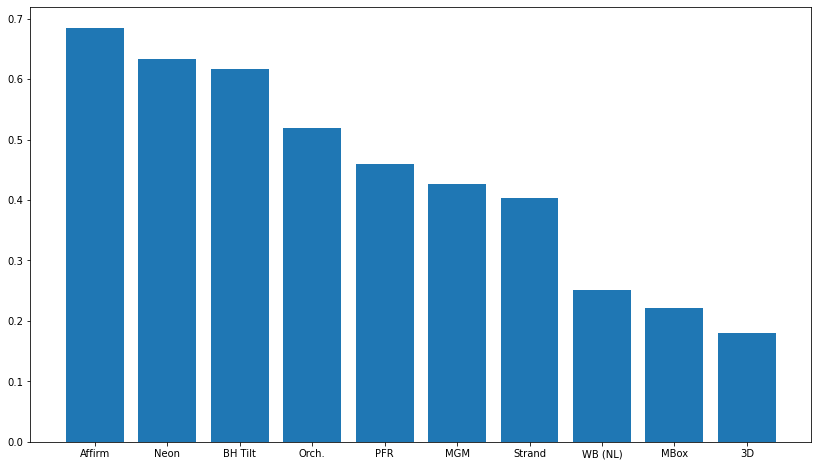

In [85]:
mega_studio = mega_studio.sort_values('dom_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(mega_studio['studio'], mega_studio['dom_profit_margin'])
ax.set_title= 'Top Studios'
ax.set_xlabel= 'Studios'
ax.set_ylabel= 'Domestic Profit Margin'

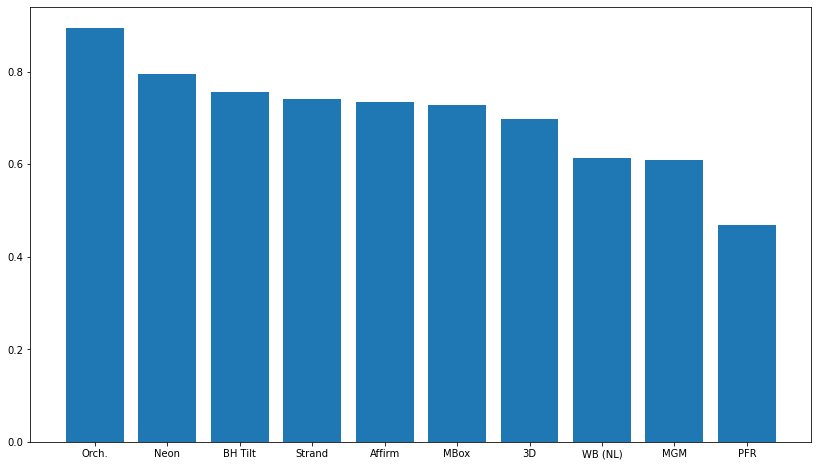

In [86]:
mega_studio = mega_studio.sort_values('ww_profit_margin', ascending=False).iloc[:10]

fig, ax= plt.subplots(figsize=(14,8))

ax.bar(mega_studio['studio'], mega_studio['ww_profit_margin'])
ax.set_title= 'Top Studios'
ax.set_xlabel= 'Studios'
ax.set_ylabel= 'Worldwide Profit Margin'

In [123]:
type(mega_movie['genre_ids'][0])

list

In [3]:
def to_1D(series):
    return pd.Series([x for genres in series for x in genres])

In [125]:
genre_list= to_1D(mega_movie['genre_ids']).value_counts()
genre_list

18       322
35       136
28       111
53       103
12        93
10749     73
878       72
80        67
10751     56
14        45
16        42
36        34
9648      30
10752     18
27        16
10402     13
99        10
37         8
dtype: int64

Text(0.5, 1.0, 'Movie Genres by Frequency')

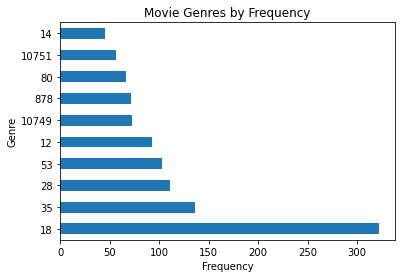

In [131]:
fig, ax= plt.subplots()

to_1D(mega_movie['genre_ids']).value_counts()[:10].plot(kind='barh')
ax.set_xlabel("Frequency")
ax.set_ylabel("Genre")
ax.set_title("Movie Genres by Frequency")